## 1. Выберите алгоритм обучения с учителем с большим числом гиперпараметров.

В качестве алгоритма обучения с учителем я выбрал CatBoost.

## 2. Выберите набор данных и целевую функцию оценки алгоритма.

Я взял классический набор данных *[California Housing](https://www.kaggle.com/datasets/camnugent/california-housing-prices)* для предсказания цен

In [1]:
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

X, y = fetch_california_housing(return_X_y=True)

In [2]:
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1, 1)).reshape(-1)

## 3. Реализуйте алгоритм байесовской оптимизации.

[metafora/hyperopt](../../metafora/hyperopt) – модуль предоставляющий методы для оптимизации гиперпараметров
- [optimizers](../../metafora/hyperopt/optimizers) – алгоритмы оптимизации
    - [bayes](../../metafora/hyperopt/optimizers/bayes.py) – алгоритм байесовской оптимизации
    - [random](../../metafora/hyperopt/optimizers/random.py) – алгоритм случайной оптимизации
- [study](../../metafora/hyperopt/study.py) – модуль реализующий цикл оптимизации гиперпараметров
- [params](../../metafora/hyperopt/params) – классы для определения возможных значений гиперпараметров
- [surrogate](../../metafora/hyperopt/surrogate) – реализация суррогатных функций, позволяющий оценивать неопределенность
    - [functions](../../metafora/hyperopt/surrogate/functions.py) – суррогатные / proxy функции
    - [acquisitions](../../metafora/hyperopt/surrogate/acquisitions.py) – функции улучшения (UCB, LBC, PI, PE)

## 4. Сравните алгоритм байесовской оптимизации со случайным поиском.

In [3]:
from metafora.hyperopt.study import Study
from metafora.hyperopt.optimizers import BayesianOptimizer, RandomOptimizer
from metafora.hyperopt.params import FloatParameter, CategoricalParameter, IntParameter, FixedParameter, HyperParameters
from metafora.hyperopt.surrogate.functions import GaussianProcessEstimator
from metafora.hyperopt.surrogate.acquisitions import ExpectedImprovement

improvement = ExpectedImprovement(slack=0.01)

surrogate = GaussianProcessEstimator(
    improvement=improvement,
    normalize_x=True,
    normalize_y=True,
    alpha=1e-6,
    n_restarts_optimizer=5
)

bayesian_optimizer = BayesianOptimizer(
    initial_samples=1,
    population_size=30,
    surrogate=surrogate
)

hyperparams = HyperParameters([
    ("learning_rate", FloatParameter(1e-3, 1, log_scale=True)),
    ("loss_function", CategoricalParameter("RMSE", "MAE", "MAPE")),
    ("l2_leaf_reg", FloatParameter(1e-3, 1, log_scale=True)),
    ("bootstrap_type", CategoricalParameter("Bayesian", "Bernoulli", "MVS")),
    ("leaf_estimation_iterations", IntParameter(1, 5)),
    ("max_ctr_complexity", IntParameter(1, 5)),
    ("random_strength", FloatParameter(1e-2, 1, log_scale=True)),
    ("iterations", IntParameter(5, 150, log_scale=True)),
    ("verbose", FixedParameter(0)),
    ("use_best_model", FixedParameter(False)),
    ("allow_writing_files", FixedParameter(False))
])

bayesian_study = Study(hyperparams, bayesian_optimizer)
random_study = Study(hyperparams, RandomOptimizer())

In [4]:
bayesian_study

Study(
	hyperparameters:
		learning_rate              : FloatParameter(lower=0.001, upper=1, log_scale=True)
		loss_function              : CategoricalParameter(RMSE, MAE, MAPE)
		l2_leaf_reg                : FloatParameter(lower=0.001, upper=1, log_scale=True)
		bootstrap_type             : CategoricalParameter(Bayesian, Bernoulli, MVS)
		leaf_estimation_iterations : IntParameter(lower=1, upper=5, log_scale=False)
		max_ctr_complexity         : IntParameter(lower=1, upper=5, log_scale=False)
		random_strength            : FloatParameter(lower=0.01, upper=1, log_scale=True)
		iterations                 : IntParameter(lower=5, upper=150, log_scale=True)
		verbose                    : FixedParameter(0)
		use_best_model             : FixedParameter(False)
		allow_writing_files        : FixedParameter(False)

	optimizer: BayesianOptimizer(improvement=ExpectedImprovement(slack=0.01))
)

In [5]:
from sklearn.model_selection import cross_val_score


def objective(params):
    """
    :param params: {"learning_rate" : 0.1, "loss_function" : "RMSE", ... }
    :return: cross validation mse loss
    """

    loss = cross_val_score(CatBoostRegressor(**params), X, y, scoring="neg_mean_absolute_error", cv=5)
    loss = -loss
    loss = loss.mean()

    return loss

In [6]:
bayesian_study.optimize(objective, episodes=40, verbose=True)
random_study.optimize(objective, episodes=40, verbose=True)

optimizing: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s, loss: 0.7089]


 ## 5. Визуализируйте пространство протестированных значений гиперпараметров. Цветом обозначьте значение целевой функции на них.

In [7]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


def pca_scatter_plot(study: Study, name: str):
    vectorized = study.hyperparams.vectorize(study.params)
    vectorized = StandardScaler().fit_transform(vectorized)

    tsne = TSNE(n_components=2, init="random", learning_rate="auto", perplexity=min(len(vectorized) - 1, 30))

    embeddings = tsne.fit_transform(vectorized)

    plt.axis("off")
    plt.title(f"{name} optimizer")
    fig = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=study.losses, cmap="Greens")
    bar = plt.colorbar(fig, orientation="horizontal")
    bar.ax.set_title("MSE loss")

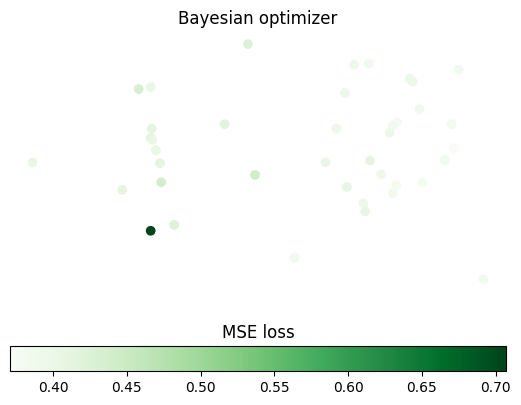

In [8]:
pca_scatter_plot(bayesian_study, name="Bayesian")

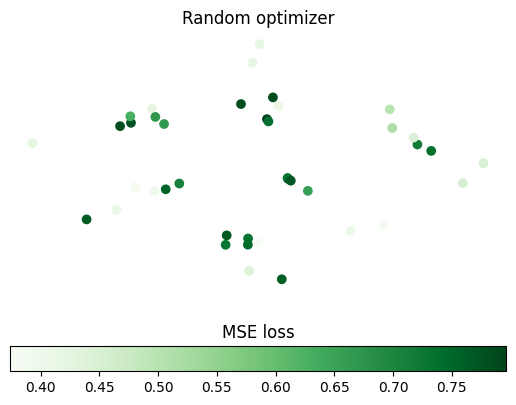

In [9]:
pca_scatter_plot(random_study, name="Random")

## Посмотрим на распределение параметров

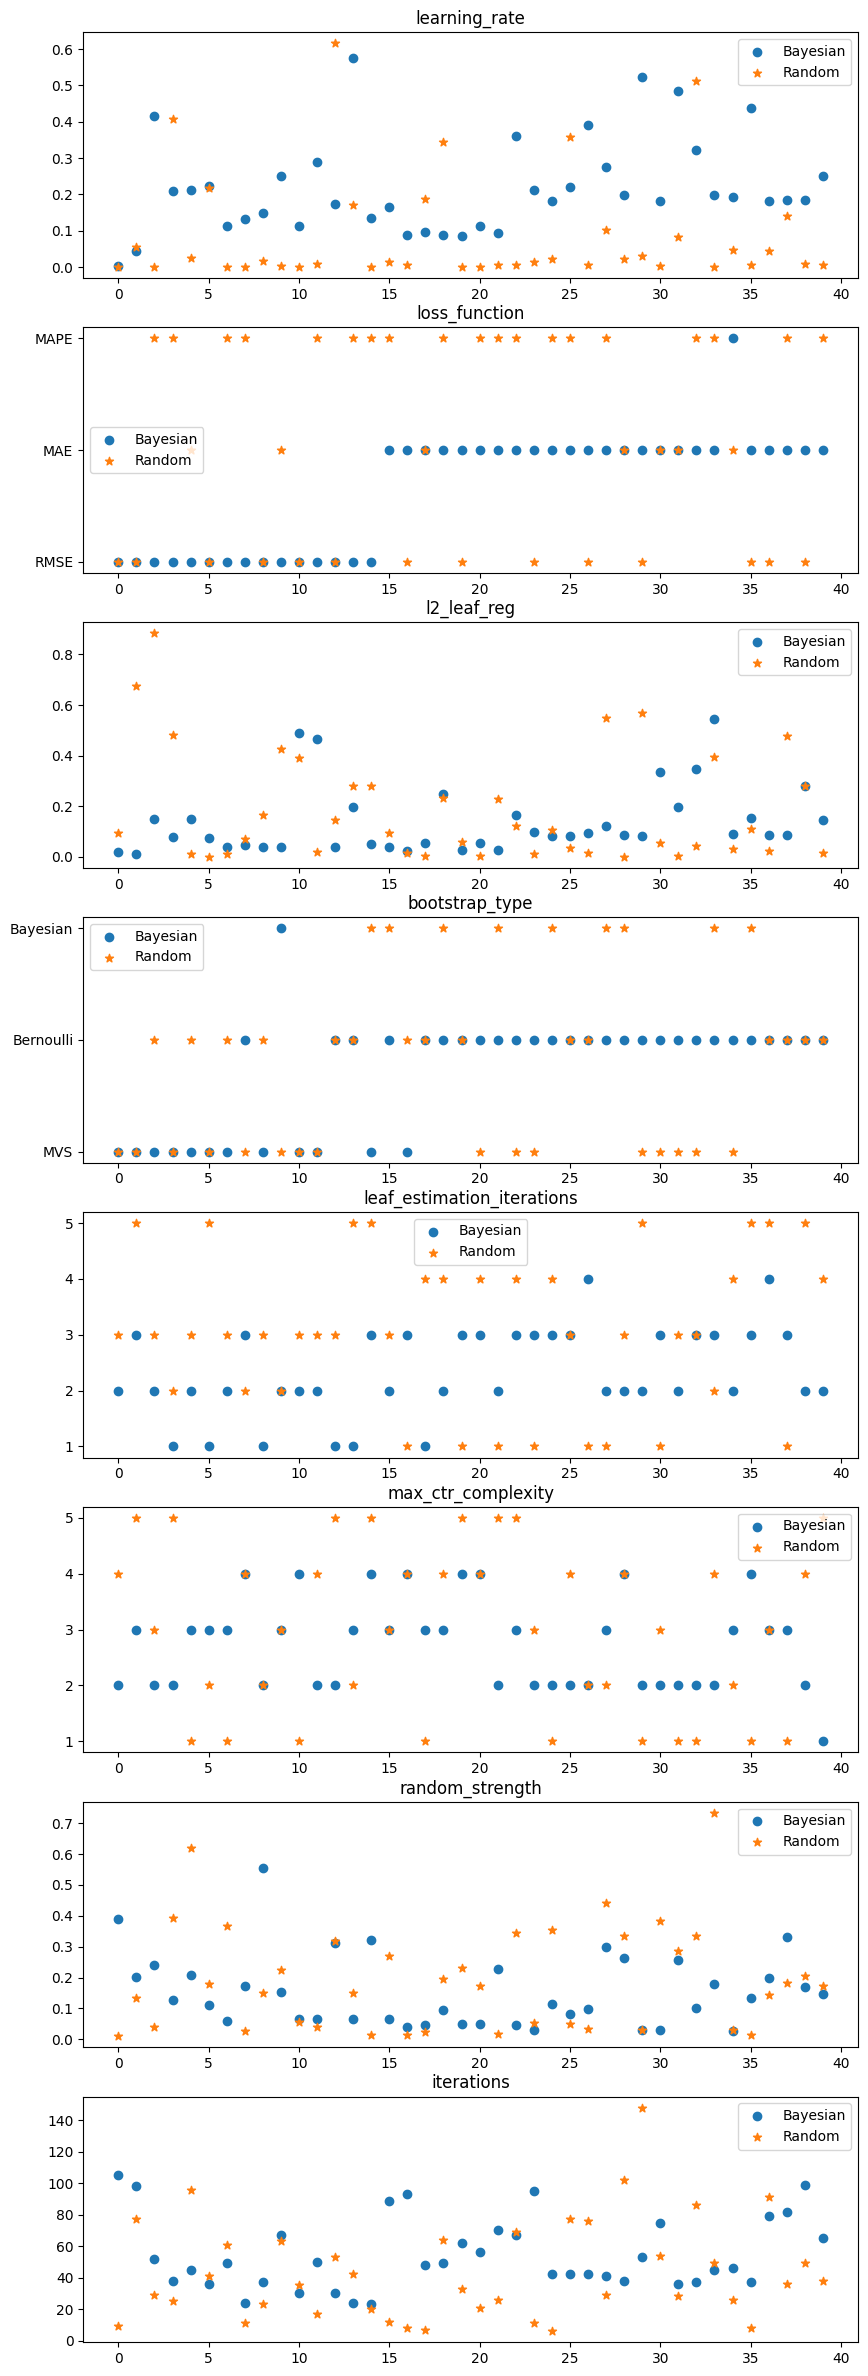

In [10]:
from collections import defaultdict

bayesian_param_values = defaultdict(list)
random_param_values = defaultdict(list)

for n in hyperparams.changeable:
    for param in bayesian_study.params:
        bayesian_param_values[n].append(param[n])

    for param in random_study.params:
        random_param_values[n].append(param[n])

_, axs = plt.subplots(len(bayesian_param_values), figsize=(10, 30))

for i, (name, bayesian_values) in enumerate(bayesian_param_values.items()):
    random_values = random_param_values[name]

    axs[i].set_title(name)
    axs[i].scatter(range(len(bayesian_values)), bayesian_values, label="Bayesian")
    axs[i].scatter(range(len(random_values)), random_values, label="Random", marker="*")
    axs[i].legend()

 ## 6. Визуализируйте значение целевой функции в зависимости от номера шага.

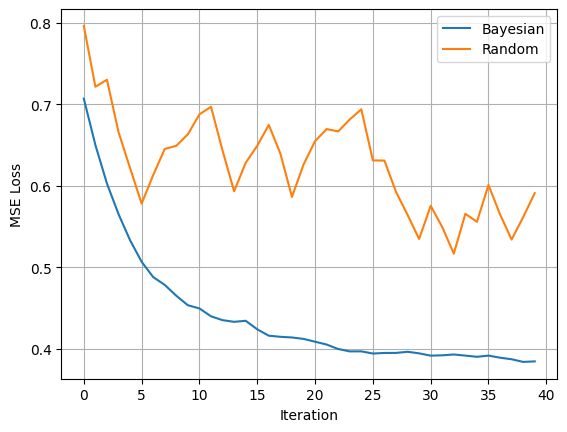

In [11]:
def smooth(values, gamma=0.8):
    x, rest = values[:1], values[1:]
    for v in rest:
        x.append(x[-1] * gamma + (1 - gamma) * v)

    return x


plt.grid()
plt.plot(smooth(bayesian_study.losses), label="Bayesian")
plt.plot(smooth(random_study.losses), label="Random")

plt.ylabel("MSE Loss")
plt.xlabel("Iteration")

plt.legend()

Более детальный график значения функции качества на каждой итерации байесовского оптимизатора

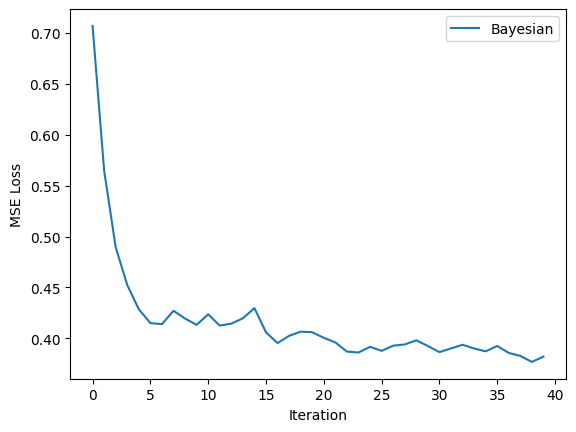

In [12]:
plt.plot(smooth(bayesian_study.losses, gamma=0.5), label="Bayesian")
plt.ylabel("MSE Loss")
plt.xlabel("Iteration")
plt.legend()

In [13]:
import json


def pretty_result(study, opt_name: str):
    print(f"Best `{opt_name.upper()}` optimizer loss: {study.best_score} reached on {study.best_step} iteration")
    print()
    print("Best params:")
    print(json.dumps(study.best_params, indent=2))


pretty_result(bayesian_study, "bayesian")

Best `BAYESIAN` optimizer loss: 0.3708911774047935 reached on 38 iteration

Best params:
{
  "learning_rate": 0.1845499764427015,
  "loss_function": "MAE",
  "l2_leaf_reg": 0.27944582078097624,
  "bootstrap_type": "Bernoulli",
  "leaf_estimation_iterations": 2,
  "max_ctr_complexity": 2,
  "random_strength": 0.16895215035390823,
  "iterations": 99,
  "verbose": 0,
  "use_best_model": false,
  "allow_writing_files": false
}


In [14]:
pretty_result(random_study, "random")

Best `RANDOM` optimizer loss: 0.3738054095927939 reached on 18 iteration

Best params:
{
  "learning_rate": 0.3456152589298895,
  "loss_function": "MAPE",
  "l2_leaf_reg": 0.23330442283765976,
  "bootstrap_type": "Bayesian",
  "leaf_estimation_iterations": 4,
  "max_ctr_complexity": 4,
  "random_strength": 0.19387372257118085,
  "iterations": 64,
  "verbose": 0,
  "use_best_model": false,
  "allow_writing_files": false
}
